<a href="https://colab.research.google.com/github/CarlosEduEstanislau/Chess/blob/main/AlgoritimoGrove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install qiskit


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 4.8 MB/s 
     |████████████████████████████████| 18.0 MB 33.1 MB/s 
     |████████████████████████████████| 240 kB 52.4 MB/s 
     |████████████████████████████████| 198 kB 38.0 MB/s 
     |████████████████████████████████| 112 kB 53.4 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 1.6 MB 33.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 943 kB 52.2 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 4.0 MB 42.0 MB/s 
     |████████████████████████████████| 112 kB 48.8 MB/s 
  Created wheel for qiskit: filename=qiskit-0.36.2-py3-none-any.whl size=11933 sha256=55b49335b

In [3]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram

In [4]:
#Aqui estou definindo algumas variaveis que vou precisar
var_qubits = QuantumRegister(4, name='v') #Definindo 4 registros quaticos para as variaveis
qubitsDeCondicao = QuantumRegister(4, name='c') #Definindo 4 registros quantisco para condição
qubitSaida = QuantumRegister(1, name='saida') #Definindo 1 restistro quantico para a saida
cbits = ClassicalRegister(4, name='cbits') #Definindo 4 registros classicos
cq = QuantumCircuit(var_qubits, qubitsDeCondicao, qubitSaida, cbits) #Aqui estou definindo meu circuito quantico


In [5]:
# Aqui vamos criar um difusor generico para utilizar no nosso problema.
def diffuser(nqubits):
    cq = QuantumCircuit(nqubits)
    # Aplicando o Haddamard para sair de |s> -> para |0000>
    for qubit in range(nqubits):
        cq.h(qubit)
    # Aplicando paulinX para transformar de |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        cq.x(qubit)
    # Aplicando MCZ
    cq.h(nqubits-1)
    cq.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    cq.h(nqubits-1)
    # Re-aplicando PaulinX
    for qubit in range(nqubits):
        cq.x(qubit)
    # Retornando ao estado |s>
    for qubit in range(nqubits):
        cq.h(qubit)
    # Vamos retornar o diffuser como uma porta
    U_s = cq.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [6]:
#Agora vamos definir a função XOR usada para comparar nossas entrdas e saidas
def XOR(cq, a, b, saida):
    #Estou aplicando o PaulinX controlado nas para sempre obter o valor que quero quando as duas entradas forem iguais
    cq.cx(a, saida)
    cq.cx(b, saida) 

In [7]:
#Agora vou criar uma lista com a coluna e a linha que tenho que testar 
listaDeCondicoes = [[0,1],[0,2],[1,3],[2,3]]

In [8]:
# Criaremos agora o algoritimo oraculo do Jogo de sudoku
def sudoku_oracle(cq, listaDeCondicoes,qubitsDeCondicao):
    # Avaliando as condições
    i = 0
    for condicoes in listaDeCondicoes:
        XOR(cq, condicoes[0], condicoes[1], qubitsDeCondicao[i])
        i += 1

    # Flipa todos os qubits caso as condições sejam satisfeitas
    cq.mct(qubitsDeCondicao, qubitSaida)

    # Resetando a lista de condições e os qubits de condições
    i = 0
    for condicoes in listaDeCondicoes:
        XOR(cq, condicoes[0], condicoes[1], qubitsDeCondicao[i])
        i += 1

sudoku_oracle(cq, listaDeCondicoes,qubitsDeCondicao)
cq.draw()

»
    v_0: ──■─────────■──────────────────────────────────■─────────■────────────»
           │         │                                  │         │            »
    v_1: ──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──»
           │    │    │         │                        │    │    │         │  »
    v_2: ──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼──»
           │    │    │    │    │         │              │    │    │    │    │  »
    v_3: ──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼──»
         ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │  »
    c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼──»
         └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │  »
    c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼──»
                   └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐»
    c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├»
                             └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘»
    c_3: ──────────────────────────────┤ X ├┤ X ├──■───────────────────────────»
                                       └───┘└───┘┌─┴─┐                         »
  saida: ────────────────────────────────────────┤ X ├─────────────────────────»
                                                 └───┘                         »
cbits: 4/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                        
«    v_0: ───────────────
«                        
«    v_1: ───────────────
«                        
«    v_2: ───────■───────
«                │       
«    v_3: ──■────┼────■──
«           │    │    │  
«    c_0: ──┼────┼────┼──
«           │    │    │  
«    c_1: ──┼────┼────┼──
«         ┌─┴─┐  │    │  
«    c_2: ┤ X ├──┼────┼──
«         └───┘┌─┴─┐┌─┴─┐
«    c_3: ─────┤ X ├┤ X ├
«              └───┘└───┘
«  saida: ───────────────
«                        
«cbits: 4/═══════════════
«

In [9]:
#Agora vamos implementar nosso circuito comploeto 

# Inicializando a saida0 no estado |->
cq.initialize([1, -1]/np.sqrt(2), qubitSaida)

# Colocando todos os qubits de variaveis no estado |s>
cq.h(var_qubits)
cq.barrier()  # Separação visual

##Primeira interação
# Aplicando o oraculo
sudoku_oracle(cq, listaDeCondicoes, qubitsDeCondicao)
cq.barrier()  # Separação visual
#Aplicando nosso diffuser
cq.append(diffuser(4), [0,1,2,3])

## Segunda interação
sudoku_oracle(cq, listaDeCondicoes, qubitsDeCondicao)
cq.barrier()  # Separação visual
#Aplicando nosso diffuser
cq.append(diffuser(4), [0,1,2,3])

# Medindo os qubits variaveis
cq.measure(var_qubits, cbits)

cq.draw(fold=-1)

┌───┐                          ░                                                                                       ░ ┌────────┐                                                                                      ░ ┌────────┐┌─┐         
    v_0: ──■─────────■───────────────────────────────────────────────■───────────────────────■──┤ H ├──────────────────────────░───■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├──■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├┤M├─────────
           │         │                                               │                       │  └───┘     ┌───┐                ░   │         │                                  │         │                            ░ │        │  │         │                                  │         │                            ░ │        │└╥┘┌─┐      
    v_1: ──┼────■────┼─────────■─────────────────────────────────────┼──────────────────■────┼─────────■──┤ H ├────────────────░───┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├─╫─┤M├──────
           │    │    │         │                                     │                  │    │         │  └───┘     ┌───┐      ░   │    │    │         │                        │    │    │         │                  ░ │  U$_s$ │  │    │    │         │                        │    │    │         │                  ░ │  U$_s$ │ ║ └╥┘┌─┐   
    v_2: ──┼────┼────┼────■────┼─────────■───────────────────────────┼──────────────────┼────┼────■────┼─────────■──┤ H ├──────░───┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├─╫──╫─┤M├───
           │    │    │    │    │         │                           │                  │    │    │    │         │  └───┘┌───┐ ░   │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │  │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │ ║  ║ └╥┘┌─┐
    v_3: ──┼────┼────┼────┼────┼────■────┼────■──────────────────────┼──────────────────┼────┼────┼────┼────■────┼────■──┤ H ├─░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├─╫──╫──╫─┤M├
         ┌─┴─┐┌─┴─┐  │    │    │    │    │    │                    ┌─┴─┐              ┌─┴─┐  │    │    │    │    │    │  └───┘ ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘ ║  ║  ║ └╥┘
    c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■───────────────┤ X ├──────────────┤ X ├──┼────┼────┼────┼────┼────┼────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░───────────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░────────────╫──╫──╫──╫─
         └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │               └───┘              └───┘┌─┴─┐┌─┴─┐  │    │    │    │        ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░            ║  ║  ║  ║ 
    c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■───────────────────────────────────────┤ X ├┤ X ├──┼────┼────┼────┼────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░─────────────────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                   └───┘└───┘┌─┴─┐┌─┴─┐ 

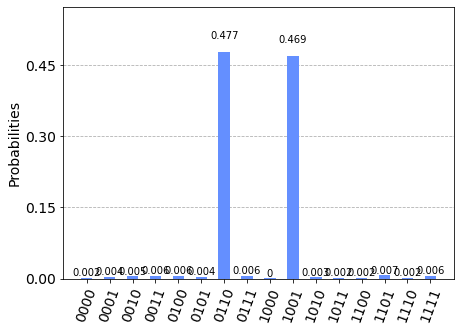

In [10]:
# Simulando e plotando os resultados
simulador = Aer.get_backend('aer_simulator')
resultado = transpile(cq, simulador)
qobj = assemble(resultado)
result =simulador.run(qobj).result()
plot_histogram(result.get_counts())